# Modeling Sentiment of Response to Promoted Tweets

Import necessary modules

In [1]:
%matplotlib inline

import pickle
import itertools
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx

from sklearn import *

/usr/local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/usr/local/lib/python2.7/site-packages/sklearn/lda.py:6: DeprecationWarning: lda.LDA has been moved to discriminant_analysis.LinearDiscriminantAnalysis in 0.17 and will be removed in 0.19
  "in 0.17 and will be removed in 0.19", DeprecationWarning)
/usr/local/lib/python2.7/site-pac

Load in tweet data. In the current model, I use 100-dimension GloVe vectors to represent promoters' timelines, repliers' timelines, and the promoted tweet itself. The Tweets directory also includes files for using 25- or 50-dimension GloVe vectors instead.

In [2]:
f = open('Tweets/tweets_glove100_df.pickle','rb')
data = pickle.load(f)
f.close()

Create columns to binarize the sentiment class of tweets.

In [3]:
data = data.assign(negative=pd.Series(data['sentiment_class'] == 'neg').values)
data = data.assign(positive=pd.Series(data['sentiment_class'] == 'pos').values)
data = data.assign(neutral=pd.Series(data['sentiment_class'] == 'neu').values)

## Data Exploration

Since I collected this data and ensured that there were no null values in the collection process, there shouldn't be any nulls in the data frame. However, it's always good to double check.

In [4]:
data.isnull().values.any()

False

Next, take a look at the distribution of sentiment across tweets in the data.

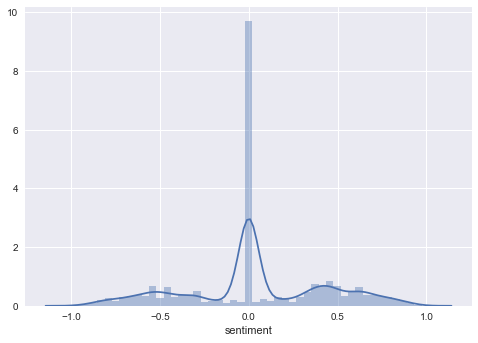

In [5]:
sns.distplot(data['sentiment'])

Many tweets have a sentiment score of exactly 0. What does the distribution look like if we filter these out?

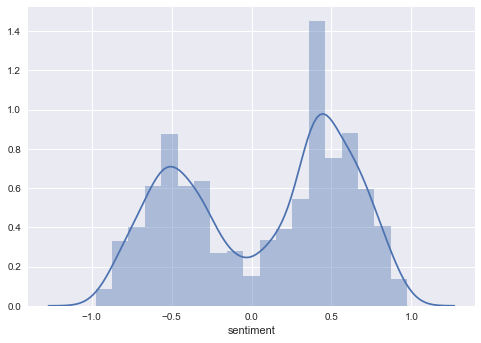

In [6]:
sns.distplot(data.loc[data.sentiment != 0]['sentiment'])

Removing the tweets with sentiment 0, the distribution is bimodal, although there are slightly more positive tweets than negative tweets.

We can look now at exactly how many tweets had positive, neutral, and negative sentiment.

In [7]:
print("Positive: %0.2f" % (float(len(data.loc[data.positive == True])) / len(data)))
print("Neutral: %0.2f" % (float(len(data.loc[data.neutral == True])) / len(data)))
print("Negative: %0.2f" % (float(len(data.loc[data.negative == True])) / len(data)))

Positive: 0.34
Neutral: 0.41
Negative: 0.25


## Models

Split data into training (80%) and test (20%) sets.

In [8]:
X = data.iloc[:, (data.columns != 'initial_company_name') & (data.columns != 'sentiment_class') & (data.columns != 'sentiment') & (data.columns != 'negative') & (data.columns != 'positive') & (data.columns != 'neutral')]
y = data.iloc[:, data.columns == 'sentiment_class']

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=100)

The first model I'll look at is a logistic regression. Since this is a multi-class classification problem, I will use a one-vs-rest classifier strategy, which is the default setting for multiclass logistic regression in scikit-learn.

First, I will use cross-validation to determine whether to use L1 or L2 regularization.

In [9]:
log_mod = linear_model.LogisticRegression()

parameters = {'penalty': ['l1','l2']}

cv = model_selection.GridSearchCV(log_mod,parameters, n_jobs = -1, cv = 10)
cv.fit(X_train, y_train.values.reshape(y_train.shape[0],))
sorted(cv.grid_scores_,key=lambda x: x.mean_validation_score,reverse=True)

/usr/local/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.47257, std: 0.00790, params: {'penalty': 'l1'},
 mean: 0.37548, std: 0.01567, params: {'penalty': 'l2'}]

From this, it looks like L1 regularization is the better choice.

In [10]:
log_mod = linear_model.LogisticRegression(penalty='l1')

log_mod.fit(X_train,y_train)
print("Accuracy: %0.3f" % log_mod.score(X_test,y_test))
print("F1 Score: %0.3f" % metrics.f1_score(y_test,log_mod.predict(X_test),average="weighted"))

/usr/local/lib/python2.7/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.489
F1 Score: 0.483


This performance represents an improvement over the baseline, since if we had just classified to the most common class in the training data (neutral), we would have achieved 41% accuracy.

I next consider a random forest classifier. First, it is necessary to do some cross-validation in order to tune hyperparameters of the model. In particular, I will look at the number of trees to include in the forest and the maximum number of features to consider at each split.

In [11]:
rf_mod = ensemble.RandomForestClassifier()

parameters = {'n_estimators': list(range(50,201,25)),
              'max_features': ['sqrt','log2']}

cv = model_selection.GridSearchCV(rf_mod,parameters, n_jobs = -1, cv = 10,verbose=2)
cv.fit(X_train, y_train.values.reshape(y_train.shape[0],))
sorted(cv.grid_scores_,key=lambda x: x.mean_validation_score,reverse=True)

Fitting 10 folds for each of 14 candidates, totalling 140 fits
[CV] max_features=sqrt, n_estimators=50 ..............................
[CV] max_features=sqrt, n_estimators=50 ..............................
[CV] max_features=sqrt, n_estimators=50 ..............................
[CV] max_features=sqrt, n_estimators=50 ..............................
[CV] ............... max_features=sqrt, n_estimators=50, total=   5.2s
[CV] max_features=sqrt, n_estimators=50 ..............................
[CV] ............... max_features=sqrt, n_estimators=50, total=   5.3s
[CV] max_features=sqrt, n_estimators=50 ..............................
[CV] ............... max_features=sqrt, n_estimators=50, total=   5.3s
[CV] max_features=sqrt, n_estimators=50 ..............................
[CV] ............... max_features=sqrt, n_estimators=50, total=   5.2s
[CV] max_features=sqrt, n_estimators=50 ..............................
[CV] ............... max_features=sqrt, n_estimators=50, total=   5.9s
[CV] max_featu

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.4min


[CV] .............. max_features=sqrt, n_estimators=125, total=  12.3s
[CV] max_features=sqrt, n_estimators=125 .............................
[CV] .............. max_features=sqrt, n_estimators=125, total=  12.4s
[CV] max_features=sqrt, n_estimators=125 .............................
[CV] .............. max_features=sqrt, n_estimators=125, total=  11.8s
[CV] max_features=sqrt, n_estimators=150 .............................
[CV] .............. max_features=sqrt, n_estimators=125, total=  11.9s
[CV] max_features=sqrt, n_estimators=150 .............................
[CV] .............. max_features=sqrt, n_estimators=125, total=  12.4s
[CV] max_features=sqrt, n_estimators=150 .............................
[CV] .............. max_features=sqrt, n_estimators=125, total=  12.6s
[CV] max_features=sqrt, n_estimators=150 .............................
[CV] .............. max_features=sqrt, n_estimators=150, total=  15.7s
[CV] .............. max_features=sqrt, n_estimators=150, total=  15.8s
[CV] m

[CV] .............. max_features=log2, n_estimators=100, total=   5.2s
[CV] max_features=log2, n_estimators=100 .............................
[CV] .............. max_features=log2, n_estimators=100, total=   5.1s
[CV] max_features=log2, n_estimators=100 .............................
[CV] .............. max_features=log2, n_estimators=100, total=   5.5s
[CV] max_features=log2, n_estimators=100 .............................
[CV] .............. max_features=log2, n_estimators=100, total=   5.5s
[CV] max_features=log2, n_estimators=100 .............................
[CV] .............. max_features=log2, n_estimators=100, total=   5.5s
[CV] max_features=log2, n_estimators=125 .............................
[CV] .............. max_features=log2, n_estimators=100, total=   5.6s
[CV] max_features=log2, n_estimators=125 .............................
[CV] .............. max_features=log2, n_estimators=100, total=   5.6s
[CV] max_features=log2, n_estimators=125 .............................
[CV] .

[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:  6.1min finished
/usr/local/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.46768, std: 0.01385, params: {'max_features': 'sqrt', 'n_estimators': 200},
 mean: 0.46578, std: 0.01310, params: {'max_features': 'sqrt', 'n_estimators': 100},
 mean: 0.46469, std: 0.01726, params: {'max_features': 'log2', 'n_estimators': 200},
 mean: 0.46388, std: 0.01313, params: {'max_features': 'sqrt', 'n_estimators': 125},
 mean: 0.46388, std: 0.01614, params: {'max_features': 'log2', 'n_estimators': 150},
 mean: 0.46374, std: 0.01479, params: {'max_features': 'sqrt', 'n_estimators': 75},
 mean: 0.46334, std: 0.01851, params: {'max_features': 'sqrt', 'n_estimators': 175},
 mean: 0.46279, std: 0.01988, params: {'max_features': 'log2', 'n_estimators': 125},
 mean: 0.46279, std: 0.01260, params: {'max_features': 'log2', 'n_estimators': 175},
 mean: 0.46184, std: 0.01024, params: {'max_features': 'sqrt', 'n_estimators': 150},
 mean: 0.45899, std: 0.01392, params: {'max_features': 'log2', 'n_estimators': 50},
 mean: 0.45777, std: 0.01072, params: {'max_features': 'log2', 'n_e

Cross-validation suggests the best random forest model has 200 trees and considers sqrt(n)
features at each split.

In [12]:
rf_mod = ensemble.RandomForestClassifier(n_estimators = 200, max_features = 'sqrt', n_jobs = -1)

rf_mod.fit(X_train,y_train)
print("Accuracy: %0.3f" % rf_mod.score(X_test,y_test))
print("F1 Score: %0.3f" % metrics.f1_score(y_test,rf_mod.predict(X_test),average="weighted"))

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


Accuracy: 0.495
F1 Score: 0.488


The random forest model performs above baseline once again, and has performance comparable to (but slightly worse than) that of the logistic regression.

I next consider a gradient boosting model. Since there are many more hyperparameters to tune than with a random forest or logistic regression, I will only use 5-fold cross-validation to speed things up.

In [13]:
gb_mod = ensemble.GradientBoostingClassifier()

parameters = {'n_estimators': [50,100,150,200],
              'max_features': ['sqrt','log2'],
              'max_depth': [2,3,4,5],
              'learning_rate': [0.05,0.1,0.15],
              'subsample': [0.6,0.8,1.]}

cv = model_selection.GridSearchCV(gb_mod,parameters, n_jobs = -1, cv = 5, verbose=2)
cv.fit(X_train, y_train.values.reshape(y_train.shape[0],))
sorted(cv.grid_scores_,key=lambda x: x.mean_validation_score,reverse=True)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
[CV] max_features=sqrt, n_estimators=50, learning_rate=0.05, max_depth=2, subsample=0.6 
[CV] max_features=sqrt, n_estimators=50, learning_rate=0.05, max_depth=2, subsample=0.6 
[CV] max_features=sqrt, n_estimators=50, learning_rate=0.05, max_depth=2, subsample=0.6 
[CV] max_features=sqrt, n_estimators=50, learning_rate=0.05, max_depth=2, subsample=0.6 
[CV]  max_features=sqrt, n_estimators=50, learning_rate=0.05, max_depth=2, subsample=0.6, total=   1.6s
[CV]  max_features=sqrt, n_estimators=50, learning_rate=0.05, max_depth=2, subsample=0.6, total=   1.6s
[CV] max_features=sqrt, n_estimators=50, learning_rate=0.05, max_depth=2, subsample=0.6 
[CV] max_features=sqrt, n_estimators=50, learning_rate=0.05, max_depth=2, subsample=0.8 
[CV]  max_features=sqrt, n_estimators=50, learning_rate=0.05, max_depth=2, subsample=0.6, total=   1.6s
[CV] max_features=sqrt, n_estimators=50, learning_rate=0.05, max_depth=2, subsample=0.8 
[

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   24.5s


[CV]  max_features=sqrt, n_estimators=150, learning_rate=0.05, max_depth=2, subsample=0.6, total=   3.9s
[CV] max_features=sqrt, n_estimators=150, learning_rate=0.05, max_depth=2, subsample=0.8 
[CV]  max_features=sqrt, n_estimators=150, learning_rate=0.05, max_depth=2, subsample=0.6, total=   3.9s
[CV] max_features=sqrt, n_estimators=150, learning_rate=0.05, max_depth=2, subsample=0.8 
[CV]  max_features=sqrt, n_estimators=150, learning_rate=0.05, max_depth=2, subsample=0.8, total=   4.0s
[CV] max_features=sqrt, n_estimators=150, learning_rate=0.05, max_depth=2, subsample=0.8 
[CV]  max_features=sqrt, n_estimators=150, learning_rate=0.05, max_depth=2, subsample=0.8, total=   4.1s
[CV] max_features=sqrt, n_estimators=150, learning_rate=0.05, max_depth=2, subsample=1.0 
[CV]  max_features=sqrt, n_estimators=150, learning_rate=0.05, max_depth=2, subsample=0.8, total=   4.0s
[CV] max_features=sqrt, n_estimators=150, learning_rate=0.05, max_depth=2, subsample=1.0 
[CV]  max_features=sqrt, 

[CV] max_features=log2, n_estimators=100, learning_rate=0.05, max_depth=2, subsample=0.6 
[CV]  max_features=log2, n_estimators=100, learning_rate=0.05, max_depth=2, subsample=0.6, total=   2.0s
[CV] max_features=log2, n_estimators=100, learning_rate=0.05, max_depth=2, subsample=0.8 
[CV]  max_features=log2, n_estimators=100, learning_rate=0.05, max_depth=2, subsample=0.6, total=   1.9s
[CV] max_features=log2, n_estimators=100, learning_rate=0.05, max_depth=2, subsample=0.8 
[CV]  max_features=log2, n_estimators=100, learning_rate=0.05, max_depth=2, subsample=0.6, total=   2.1s
[CV] max_features=log2, n_estimators=100, learning_rate=0.05, max_depth=2, subsample=0.8 
[CV]  max_features=log2, n_estimators=100, learning_rate=0.05, max_depth=2, subsample=0.6, total=   2.4s
[CV]  max_features=log2, n_estimators=100, learning_rate=0.05, max_depth=2, subsample=0.8, total=   2.4s
[CV] max_features=log2, n_estimators=100, learning_rate=0.05, max_depth=2, subsample=0.8 
[CV] max_features=log2, n

[CV]  max_features=log2, n_estimators=200, learning_rate=0.05, max_depth=2, subsample=1.0, total=   3.7s
[CV] max_features=sqrt, n_estimators=50, learning_rate=0.05, max_depth=3, subsample=0.6 
[CV]  max_features=sqrt, n_estimators=50, learning_rate=0.05, max_depth=3, subsample=0.6, total=   2.1s
[CV] max_features=sqrt, n_estimators=50, learning_rate=0.05, max_depth=3, subsample=0.6 
[CV]  max_features=sqrt, n_estimators=50, learning_rate=0.05, max_depth=3, subsample=0.6, total=   2.2s
[CV] max_features=sqrt, n_estimators=50, learning_rate=0.05, max_depth=3, subsample=0.6 
[CV]  max_features=log2, n_estimators=200, learning_rate=0.05, max_depth=2, subsample=1.0, total=   3.4s
[CV] max_features=sqrt, n_estimators=50, learning_rate=0.05, max_depth=3, subsample=0.8 
[CV]  max_features=sqrt, n_estimators=50, learning_rate=0.05, max_depth=3, subsample=0.6, total=   2.0s
[CV] max_features=sqrt, n_estimators=50, learning_rate=0.05, max_depth=3, subsample=0.8 
[CV]  max_features=sqrt, n_estima

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.3min


[CV]  max_features=sqrt, n_estimators=150, learning_rate=0.05, max_depth=3, subsample=0.6, total=   6.9s
[CV] max_features=sqrt, n_estimators=150, learning_rate=0.05, max_depth=3, subsample=0.8 
[CV]  max_features=sqrt, n_estimators=150, learning_rate=0.05, max_depth=3, subsample=0.8, total=   7.3s
[CV] max_features=sqrt, n_estimators=150, learning_rate=0.05, max_depth=3, subsample=0.8 
[CV]  max_features=sqrt, n_estimators=150, learning_rate=0.05, max_depth=3, subsample=0.8, total=   7.2s
[CV] max_features=sqrt, n_estimators=150, learning_rate=0.05, max_depth=3, subsample=1.0 
[CV]  max_features=sqrt, n_estimators=150, learning_rate=0.05, max_depth=3, subsample=0.8, total=   7.2s
[CV] max_features=sqrt, n_estimators=150, learning_rate=0.05, max_depth=3, subsample=1.0 
[CV]  max_features=sqrt, n_estimators=150, learning_rate=0.05, max_depth=3, subsample=0.8, total=   7.0s
[CV] max_features=sqrt, n_estimators=150, learning_rate=0.05, max_depth=3, subsample=1.0 
[CV]  max_features=sqrt, 

[CV] max_features=log2, n_estimators=100, learning_rate=0.05, max_depth=3, subsample=0.8 
[CV]  max_features=log2, n_estimators=100, learning_rate=0.05, max_depth=3, subsample=0.6, total=   2.5s
[CV] max_features=log2, n_estimators=100, learning_rate=0.05, max_depth=3, subsample=0.8 
[CV]  max_features=log2, n_estimators=100, learning_rate=0.05, max_depth=3, subsample=0.6, total=   2.4s
[CV] max_features=log2, n_estimators=100, learning_rate=0.05, max_depth=3, subsample=0.8 
[CV]  max_features=log2, n_estimators=100, learning_rate=0.05, max_depth=3, subsample=0.6, total=   2.4s
[CV] max_features=log2, n_estimators=100, learning_rate=0.05, max_depth=3, subsample=0.8 
[CV]  max_features=log2, n_estimators=100, learning_rate=0.05, max_depth=3, subsample=0.8, total=   2.5s
[CV] max_features=log2, n_estimators=100, learning_rate=0.05, max_depth=3, subsample=0.8 
[CV]  max_features=log2, n_estimators=100, learning_rate=0.05, max_depth=3, subsample=0.8, total=   2.5s
[CV] max_features=log2, n

[CV]  max_features=sqrt, n_estimators=50, learning_rate=0.05, max_depth=4, subsample=0.6, total=   2.6s
[CV] max_features=sqrt, n_estimators=50, learning_rate=0.05, max_depth=4, subsample=0.6 
[CV]  max_features=log2, n_estimators=200, learning_rate=0.05, max_depth=3, subsample=1.0, total=   4.5s
[CV] max_features=sqrt, n_estimators=50, learning_rate=0.05, max_depth=4, subsample=0.6 
[CV]  max_features=sqrt, n_estimators=50, learning_rate=0.05, max_depth=4, subsample=0.6, total=   2.6s
[CV] max_features=sqrt, n_estimators=50, learning_rate=0.05, max_depth=4, subsample=0.8 
[CV]  max_features=sqrt, n_estimators=50, learning_rate=0.05, max_depth=4, subsample=0.6, total=   2.6s
[CV] max_features=sqrt, n_estimators=50, learning_rate=0.05, max_depth=4, subsample=0.8 
[CV]  max_features=sqrt, n_estimators=50, learning_rate=0.05, max_depth=4, subsample=0.6, total=   2.7s
[CV] max_features=sqrt, n_estimators=50, learning_rate=0.05, max_depth=4, subsample=0.8 
[CV]  max_features=sqrt, n_estimat

[CV] max_features=sqrt, n_estimators=200, learning_rate=0.05, max_depth=4, subsample=0.6 
[CV]  max_features=sqrt, n_estimators=150, learning_rate=0.05, max_depth=4, subsample=1.0, total=   8.1s
[CV] max_features=sqrt, n_estimators=200, learning_rate=0.05, max_depth=4, subsample=0.6 
[CV]  max_features=sqrt, n_estimators=150, learning_rate=0.05, max_depth=4, subsample=1.0, total=   8.1s
[CV] max_features=sqrt, n_estimators=200, learning_rate=0.05, max_depth=4, subsample=0.6 
[CV]  max_features=sqrt, n_estimators=150, learning_rate=0.05, max_depth=4, subsample=1.0, total=   8.0s
[CV] max_features=sqrt, n_estimators=200, learning_rate=0.05, max_depth=4, subsample=0.6 
[CV]  max_features=sqrt, n_estimators=200, learning_rate=0.05, max_depth=4, subsample=0.6, total=   9.4s
[CV] max_features=sqrt, n_estimators=200, learning_rate=0.05, max_depth=4, subsample=0.6 
[CV]  max_features=sqrt, n_estimators=200, learning_rate=0.05, max_depth=4, subsample=0.6, total=   9.6s
[CV] max_features=sqrt, n

[CV]  max_features=log2, n_estimators=100, learning_rate=0.05, max_depth=4, subsample=0.8, total=   3.1s
[CV] max_features=log2, n_estimators=100, learning_rate=0.05, max_depth=4, subsample=1.0 
[CV]  max_features=log2, n_estimators=100, learning_rate=0.05, max_depth=4, subsample=1.0, total=   3.1s
[CV] max_features=log2, n_estimators=100, learning_rate=0.05, max_depth=4, subsample=1.0 
[CV]  max_features=log2, n_estimators=100, learning_rate=0.05, max_depth=4, subsample=1.0, total=   3.2s
[CV] max_features=log2, n_estimators=150, learning_rate=0.05, max_depth=4, subsample=0.6 
[CV]  max_features=log2, n_estimators=100, learning_rate=0.05, max_depth=4, subsample=1.0, total=   3.4s
[CV] max_features=log2, n_estimators=150, learning_rate=0.05, max_depth=4, subsample=0.6 
[CV]  max_features=log2, n_estimators=100, learning_rate=0.05, max_depth=4, subsample=1.0, total=   3.4s
[CV] max_features=log2, n_estimators=150, learning_rate=0.05, max_depth=4, subsample=0.6 
[CV]  max_features=log2, 

[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  6.8min


[CV]  max_features=log2, n_estimators=200, learning_rate=0.05, max_depth=4, subsample=1.0, total=   6.1s
[CV] max_features=sqrt, n_estimators=50, learning_rate=0.05, max_depth=5, subsample=0.6 
[CV]  max_features=log2, n_estimators=200, learning_rate=0.05, max_depth=4, subsample=1.0, total=   6.3s
[CV] max_features=sqrt, n_estimators=50, learning_rate=0.05, max_depth=5, subsample=0.6 
[CV]  max_features=sqrt, n_estimators=50, learning_rate=0.05, max_depth=5, subsample=0.6, total=   3.7s
[CV] max_features=sqrt, n_estimators=50, learning_rate=0.05, max_depth=5, subsample=0.6 
[CV]  max_features=sqrt, n_estimators=50, learning_rate=0.05, max_depth=5, subsample=0.6, total=   3.5s
[CV] max_features=sqrt, n_estimators=50, learning_rate=0.05, max_depth=5, subsample=0.6 
[CV]  max_features=log2, n_estimators=200, learning_rate=0.05, max_depth=4, subsample=1.0, total=   6.4s
[CV] max_features=sqrt, n_estimators=50, learning_rate=0.05, max_depth=5, subsample=0.8 
[CV]  max_features=sqrt, n_estim

[CV] max_features=sqrt, n_estimators=150, learning_rate=0.05, max_depth=5, subsample=1.0 
[CV]  max_features=sqrt, n_estimators=150, learning_rate=0.05, max_depth=5, subsample=1.0, total=  11.3s
[CV] max_features=sqrt, n_estimators=150, learning_rate=0.05, max_depth=5, subsample=1.0 
[CV]  max_features=sqrt, n_estimators=150, learning_rate=0.05, max_depth=5, subsample=1.0, total=  11.3s
[CV] max_features=sqrt, n_estimators=200, learning_rate=0.05, max_depth=5, subsample=0.6 
[CV]  max_features=sqrt, n_estimators=150, learning_rate=0.05, max_depth=5, subsample=1.0, total=  11.3s
[CV] max_features=sqrt, n_estimators=200, learning_rate=0.05, max_depth=5, subsample=0.6 
[CV]  max_features=sqrt, n_estimators=150, learning_rate=0.05, max_depth=5, subsample=1.0, total=  11.4s
[CV] max_features=sqrt, n_estimators=200, learning_rate=0.05, max_depth=5, subsample=0.6 
[CV]  max_features=sqrt, n_estimators=150, learning_rate=0.05, max_depth=5, subsample=1.0, total=  11.4s
[CV] max_features=sqrt, n

[CV]  max_features=log2, n_estimators=100, learning_rate=0.05, max_depth=5, subsample=0.8, total=   4.2s
[CV] max_features=log2, n_estimators=100, learning_rate=0.05, max_depth=5, subsample=1.0 
[CV]  max_features=log2, n_estimators=100, learning_rate=0.05, max_depth=5, subsample=0.8, total=   4.2s
[CV] max_features=log2, n_estimators=100, learning_rate=0.05, max_depth=5, subsample=1.0 
[CV]  max_features=log2, n_estimators=100, learning_rate=0.05, max_depth=5, subsample=0.8, total=   4.1s
[CV] max_features=log2, n_estimators=100, learning_rate=0.05, max_depth=5, subsample=1.0 
[CV]  max_features=log2, n_estimators=100, learning_rate=0.05, max_depth=5, subsample=1.0, total=   4.2s
[CV] max_features=log2, n_estimators=100, learning_rate=0.05, max_depth=5, subsample=1.0 
[CV]  max_features=log2, n_estimators=100, learning_rate=0.05, max_depth=5, subsample=1.0, total=   4.2s
[CV] max_features=log2, n_estimators=150, learning_rate=0.05, max_depth=5, subsample=0.6 
[CV]  max_features=log2, 

[CV] max_features=sqrt, n_estimators=50, learning_rate=0.1, max_depth=2, subsample=0.8 
[CV]  max_features=sqrt, n_estimators=50, learning_rate=0.1, max_depth=2, subsample=0.8, total=   1.6s
[CV] max_features=sqrt, n_estimators=50, learning_rate=0.1, max_depth=2, subsample=0.8 
[CV]  max_features=sqrt, n_estimators=50, learning_rate=0.1, max_depth=2, subsample=0.8, total=   1.6s
[CV] max_features=sqrt, n_estimators=50, learning_rate=0.1, max_depth=2, subsample=1.0 
[CV]  max_features=sqrt, n_estimators=50, learning_rate=0.1, max_depth=2, subsample=0.8, total=   1.6s
[CV] max_features=sqrt, n_estimators=50, learning_rate=0.1, max_depth=2, subsample=1.0 
[CV]  max_features=log2, n_estimators=200, learning_rate=0.05, max_depth=5, subsample=1.0, total=   8.5s
[CV] max_features=sqrt, n_estimators=50, learning_rate=0.1, max_depth=2, subsample=1.0 
[CV]  max_features=sqrt, n_estimators=50, learning_rate=0.1, max_depth=2, subsample=0.8, total=   1.6s
[CV] max_features=sqrt, n_estimators=50, le

[CV] max_features=sqrt, n_estimators=200, learning_rate=0.1, max_depth=2, subsample=0.8 
[CV]  max_features=sqrt, n_estimators=200, learning_rate=0.1, max_depth=2, subsample=0.6, total=   4.9s
[CV] max_features=sqrt, n_estimators=200, learning_rate=0.1, max_depth=2, subsample=0.8 
[CV]  max_features=sqrt, n_estimators=200, learning_rate=0.1, max_depth=2, subsample=0.6, total=   5.0s
[CV] max_features=sqrt, n_estimators=200, learning_rate=0.1, max_depth=2, subsample=0.8 
[CV]  max_features=sqrt, n_estimators=200, learning_rate=0.1, max_depth=2, subsample=0.8, total=   5.1s
[CV] max_features=sqrt, n_estimators=200, learning_rate=0.1, max_depth=2, subsample=0.8 
[CV]  max_features=sqrt, n_estimators=200, learning_rate=0.1, max_depth=2, subsample=0.8, total=   5.2s
[CV] max_features=sqrt, n_estimators=200, learning_rate=0.1, max_depth=2, subsample=1.0 
[CV]  max_features=sqrt, n_estimators=200, learning_rate=0.1, max_depth=2, subsample=0.8, total=   5.2s
[CV] max_features=sqrt, n_estimator

[CV] max_features=log2, n_estimators=150, learning_rate=0.1, max_depth=2, subsample=0.6 
[CV]  max_features=log2, n_estimators=150, learning_rate=0.1, max_depth=2, subsample=0.6, total=   2.6s
[CV] max_features=log2, n_estimators=150, learning_rate=0.1, max_depth=2, subsample=0.8 
[CV]  max_features=log2, n_estimators=150, learning_rate=0.1, max_depth=2, subsample=0.6, total=   2.6s
[CV] max_features=log2, n_estimators=150, learning_rate=0.1, max_depth=2, subsample=0.8 
[CV]  max_features=log2, n_estimators=150, learning_rate=0.1, max_depth=2, subsample=0.6, total=   2.6s
[CV] max_features=log2, n_estimators=150, learning_rate=0.1, max_depth=2, subsample=0.8 
[CV]  max_features=log2, n_estimators=150, learning_rate=0.1, max_depth=2, subsample=0.6, total=   2.7s
[CV] max_features=log2, n_estimators=150, learning_rate=0.1, max_depth=2, subsample=0.8 
[CV]  max_features=log2, n_estimators=150, learning_rate=0.1, max_depth=2, subsample=0.8, total=   2.7s
[CV] max_features=log2, n_estimator

[CV] max_features=sqrt, n_estimators=100, learning_rate=0.1, max_depth=3, subsample=0.6 
[CV]  max_features=sqrt, n_estimators=50, learning_rate=0.1, max_depth=3, subsample=1.0, total=   2.2s
[CV] max_features=sqrt, n_estimators=100, learning_rate=0.1, max_depth=3, subsample=0.6 
[CV]  max_features=sqrt, n_estimators=100, learning_rate=0.1, max_depth=3, subsample=0.6, total=   3.6s
[CV] max_features=sqrt, n_estimators=100, learning_rate=0.1, max_depth=3, subsample=0.6 
[CV]  max_features=sqrt, n_estimators=100, learning_rate=0.1, max_depth=3, subsample=0.6, total=   3.7s
[CV] max_features=sqrt, n_estimators=100, learning_rate=0.1, max_depth=3, subsample=0.8 
[CV]  max_features=sqrt, n_estimators=100, learning_rate=0.1, max_depth=3, subsample=0.6, total=   3.6s
[CV] max_features=sqrt, n_estimators=100, learning_rate=0.1, max_depth=3, subsample=0.8 
[CV]  max_features=sqrt, n_estimators=100, learning_rate=0.1, max_depth=3, subsample=0.6, total=   3.7s
[CV] max_features=sqrt, n_estimators

[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 12.9min


[CV]  max_features=sqrt, n_estimators=150, learning_rate=0.1, max_depth=3, subsample=1.0, total=   5.7s
[CV] max_features=sqrt, n_estimators=150, learning_rate=0.1, max_depth=3, subsample=1.0 
[CV]  max_features=sqrt, n_estimators=150, learning_rate=0.1, max_depth=3, subsample=1.0, total=   5.8s
[CV] max_features=sqrt, n_estimators=200, learning_rate=0.1, max_depth=3, subsample=0.6 
[CV]  max_features=sqrt, n_estimators=150, learning_rate=0.1, max_depth=3, subsample=1.0, total=   5.8s
[CV] max_features=sqrt, n_estimators=200, learning_rate=0.1, max_depth=3, subsample=0.6 
[CV]  max_features=sqrt, n_estimators=150, learning_rate=0.1, max_depth=3, subsample=1.0, total=   5.8s
[CV] max_features=sqrt, n_estimators=200, learning_rate=0.1, max_depth=3, subsample=0.6 
[CV]  max_features=sqrt, n_estimators=150, learning_rate=0.1, max_depth=3, subsample=1.0, total=   5.8s
[CV] max_features=sqrt, n_estimators=200, learning_rate=0.1, max_depth=3, subsample=0.6 
[CV]  max_features=sqrt, n_estimato

[CV]  max_features=log2, n_estimators=100, learning_rate=0.1, max_depth=3, subsample=0.8, total=   2.5s
[CV] max_features=log2, n_estimators=100, learning_rate=0.1, max_depth=3, subsample=1.0 
[CV]  max_features=log2, n_estimators=100, learning_rate=0.1, max_depth=3, subsample=0.8, total=   2.4s
[CV] max_features=log2, n_estimators=100, learning_rate=0.1, max_depth=3, subsample=1.0 
[CV]  max_features=log2, n_estimators=100, learning_rate=0.1, max_depth=3, subsample=1.0, total=   2.5s
[CV] max_features=log2, n_estimators=100, learning_rate=0.1, max_depth=3, subsample=1.0 
[CV]  max_features=log2, n_estimators=100, learning_rate=0.1, max_depth=3, subsample=1.0, total=   2.4s
[CV] max_features=log2, n_estimators=150, learning_rate=0.1, max_depth=3, subsample=0.6 
[CV]  max_features=log2, n_estimators=100, learning_rate=0.1, max_depth=3, subsample=1.0, total=   2.4s
[CV] max_features=log2, n_estimators=150, learning_rate=0.1, max_depth=3, subsample=0.6 
[CV]  max_features=log2, n_estimato

[CV] max_features=sqrt, n_estimators=50, learning_rate=0.1, max_depth=4, subsample=0.8 
[CV]  max_features=sqrt, n_estimators=50, learning_rate=0.1, max_depth=4, subsample=0.8, total=   2.8s
[CV]  max_features=sqrt, n_estimators=50, learning_rate=0.1, max_depth=4, subsample=0.8, total=   2.9s
[CV] max_features=sqrt, n_estimators=50, learning_rate=0.1, max_depth=4, subsample=1.0 
[CV] max_features=sqrt, n_estimators=50, learning_rate=0.1, max_depth=4, subsample=1.0 
[CV]  max_features=sqrt, n_estimators=50, learning_rate=0.1, max_depth=4, subsample=0.8, total=   2.8s
[CV] max_features=sqrt, n_estimators=50, learning_rate=0.1, max_depth=4, subsample=1.0 
[CV]  max_features=sqrt, n_estimators=50, learning_rate=0.1, max_depth=4, subsample=0.8, total=   2.9s
[CV] max_features=sqrt, n_estimators=50, learning_rate=0.1, max_depth=4, subsample=1.0 
[CV]  max_features=sqrt, n_estimators=50, learning_rate=0.1, max_depth=4, subsample=1.0, total=   2.9s
[CV]  max_features=sqrt, n_estimators=50, lea

[CV] max_features=sqrt, n_estimators=200, learning_rate=0.1, max_depth=4, subsample=0.8 
[CV]  max_features=sqrt, n_estimators=200, learning_rate=0.1, max_depth=4, subsample=0.6, total=   9.6s
[CV] max_features=sqrt, n_estimators=200, learning_rate=0.1, max_depth=4, subsample=0.8 
[CV]  max_features=sqrt, n_estimators=200, learning_rate=0.1, max_depth=4, subsample=0.8, total=  36.1s
[CV] max_features=sqrt, n_estimators=200, learning_rate=0.1, max_depth=4, subsample=0.8 
[CV]  max_features=sqrt, n_estimators=200, learning_rate=0.1, max_depth=4, subsample=0.8, total=  36.2s
[CV] max_features=sqrt, n_estimators=200, learning_rate=0.1, max_depth=4, subsample=1.0 
[CV]  max_features=sqrt, n_estimators=200, learning_rate=0.1, max_depth=4, subsample=0.8, total=  36.3s
[CV] max_features=sqrt, n_estimators=200, learning_rate=0.1, max_depth=4, subsample=1.0 
[CV]  max_features=sqrt, n_estimators=200, learning_rate=0.1, max_depth=4, subsample=0.8, total=  36.5s
[CV] max_features=sqrt, n_estimator

[CV] max_features=log2, n_estimators=150, learning_rate=0.1, max_depth=4, subsample=0.8 
[CV]  max_features=log2, n_estimators=150, learning_rate=0.1, max_depth=4, subsample=0.6, total=   5.1s
[CV] max_features=log2, n_estimators=150, learning_rate=0.1, max_depth=4, subsample=0.8 
[CV]  max_features=log2, n_estimators=150, learning_rate=0.1, max_depth=4, subsample=0.6, total=   5.1s
[CV] max_features=log2, n_estimators=150, learning_rate=0.1, max_depth=4, subsample=0.8 
[CV]  max_features=log2, n_estimators=150, learning_rate=0.1, max_depth=4, subsample=0.6, total=   5.2s
[CV] max_features=log2, n_estimators=150, learning_rate=0.1, max_depth=4, subsample=0.8 
[CV]  max_features=log2, n_estimators=150, learning_rate=0.1, max_depth=4, subsample=0.8, total=   4.9s
[CV] max_features=log2, n_estimators=150, learning_rate=0.1, max_depth=4, subsample=0.8 
[CV]  max_features=log2, n_estimators=150, learning_rate=0.1, max_depth=4, subsample=0.8, total=   4.9s
[CV] max_features=log2, n_estimator

[CV] max_features=sqrt, n_estimators=100, learning_rate=0.1, max_depth=5, subsample=0.6 
[CV]  max_features=sqrt, n_estimators=100, learning_rate=0.1, max_depth=5, subsample=0.6, total=   6.9s
[CV] max_features=sqrt, n_estimators=100, learning_rate=0.1, max_depth=5, subsample=0.6 
[CV]  max_features=sqrt, n_estimators=100, learning_rate=0.1, max_depth=5, subsample=0.6, total=   6.8s
[CV] max_features=sqrt, n_estimators=100, learning_rate=0.1, max_depth=5, subsample=0.8 
[CV]  max_features=sqrt, n_estimators=100, learning_rate=0.1, max_depth=5, subsample=0.6, total=   6.9s
[CV] max_features=sqrt, n_estimators=100, learning_rate=0.1, max_depth=5, subsample=0.8 
[CV]  max_features=sqrt, n_estimators=100, learning_rate=0.1, max_depth=5, subsample=0.6, total=   7.1s
[CV] max_features=sqrt, n_estimators=100, learning_rate=0.1, max_depth=5, subsample=0.8 
[CV]  max_features=sqrt, n_estimators=100, learning_rate=0.1, max_depth=5, subsample=0.6, total=   7.1s
[CV] max_features=sqrt, n_estimator

[CV]  max_features=log2, n_estimators=50, learning_rate=0.1, max_depth=5, subsample=0.6, total=   2.2s
[CV] max_features=log2, n_estimators=50, learning_rate=0.1, max_depth=5, subsample=0.6 
[CV]  max_features=sqrt, n_estimators=200, learning_rate=0.1, max_depth=5, subsample=1.0, total=  16.2s
[CV] max_features=log2, n_estimators=50, learning_rate=0.1, max_depth=5, subsample=0.6 
[CV]  max_features=log2, n_estimators=50, learning_rate=0.1, max_depth=5, subsample=0.6, total=   2.3s
[CV] max_features=log2, n_estimators=50, learning_rate=0.1, max_depth=5, subsample=0.6 
[CV]  max_features=log2, n_estimators=50, learning_rate=0.1, max_depth=5, subsample=0.6, total=   2.3s
[CV] max_features=log2, n_estimators=50, learning_rate=0.1, max_depth=5, subsample=0.6 
[CV]  max_features=log2, n_estimators=50, learning_rate=0.1, max_depth=5, subsample=0.6, total=   2.1s
[CV] max_features=log2, n_estimators=50, learning_rate=0.1, max_depth=5, subsample=0.8 
[CV]  max_features=log2, n_estimators=50, le

[CV]  max_features=log2, n_estimators=150, learning_rate=0.1, max_depth=5, subsample=1.0, total=   7.2s
[CV] max_features=log2, n_estimators=150, learning_rate=0.1, max_depth=5, subsample=1.0 
[CV]  max_features=log2, n_estimators=150, learning_rate=0.1, max_depth=5, subsample=1.0, total=   7.2s
[CV] max_features=log2, n_estimators=200, learning_rate=0.1, max_depth=5, subsample=0.6 
[CV]  max_features=log2, n_estimators=150, learning_rate=0.1, max_depth=5, subsample=1.0, total=   7.6s
[CV] max_features=log2, n_estimators=200, learning_rate=0.1, max_depth=5, subsample=0.6 
[CV]  max_features=log2, n_estimators=150, learning_rate=0.1, max_depth=5, subsample=1.0, total=   8.2s
[CV] max_features=log2, n_estimators=200, learning_rate=0.1, max_depth=5, subsample=0.6 
[CV]  max_features=log2, n_estimators=150, learning_rate=0.1, max_depth=5, subsample=1.0, total=   7.8s
[CV] max_features=log2, n_estimators=200, learning_rate=0.1, max_depth=5, subsample=0.6 
[CV]  max_features=log2, n_estimato

[CV] max_features=sqrt, n_estimators=100, learning_rate=0.15, max_depth=2, subsample=1.0 
[CV]  max_features=sqrt, n_estimators=100, learning_rate=0.15, max_depth=2, subsample=0.8, total=   3.5s
[CV]  max_features=sqrt, n_estimators=100, learning_rate=0.15, max_depth=2, subsample=0.8, total=   3.6s
[CV] max_features=sqrt, n_estimators=100, learning_rate=0.15, max_depth=2, subsample=1.0 
[CV] max_features=sqrt, n_estimators=100, learning_rate=0.15, max_depth=2, subsample=1.0 
[CV]  max_features=sqrt, n_estimators=100, learning_rate=0.15, max_depth=2, subsample=1.0, total=   4.0s
[CV] max_features=sqrt, n_estimators=100, learning_rate=0.15, max_depth=2, subsample=1.0 
[CV]  max_features=sqrt, n_estimators=100, learning_rate=0.15, max_depth=2, subsample=1.0, total=   4.2s
[CV] max_features=sqrt, n_estimators=150, learning_rate=0.15, max_depth=2, subsample=0.6 
[CV]  max_features=sqrt, n_estimators=100, learning_rate=0.15, max_depth=2, subsample=1.0, total=   4.1s
[CV] max_features=sqrt, n

[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed: 33.8min


[CV]  max_features=sqrt, n_estimators=200, learning_rate=0.15, max_depth=2, subsample=0.6, total=   6.6s
[CV] max_features=sqrt, n_estimators=200, learning_rate=0.15, max_depth=2, subsample=0.6 
[CV]  max_features=sqrt, n_estimators=200, learning_rate=0.15, max_depth=2, subsample=0.6, total=   6.9s
[CV] max_features=sqrt, n_estimators=200, learning_rate=0.15, max_depth=2, subsample=0.8 
[CV]  max_features=sqrt, n_estimators=200, learning_rate=0.15, max_depth=2, subsample=0.6, total=   6.2s
[CV] max_features=sqrt, n_estimators=200, learning_rate=0.15, max_depth=2, subsample=0.8 
[CV]  max_features=sqrt, n_estimators=200, learning_rate=0.15, max_depth=2, subsample=0.6, total=   6.2s
[CV] max_features=sqrt, n_estimators=200, learning_rate=0.15, max_depth=2, subsample=0.8 
[CV]  max_features=sqrt, n_estimators=200, learning_rate=0.15, max_depth=2, subsample=0.6, total=   6.0s
[CV] max_features=sqrt, n_estimators=200, learning_rate=0.15, max_depth=2, subsample=0.8 
[CV]  max_features=sqrt, 

[CV] max_features=log2, n_estimators=150, learning_rate=0.15, max_depth=2, subsample=0.6 
[CV]  max_features=log2, n_estimators=100, learning_rate=0.15, max_depth=2, subsample=1.0, total=   3.2s
[CV] max_features=log2, n_estimators=150, learning_rate=0.15, max_depth=2, subsample=0.6 
[CV]  max_features=log2, n_estimators=100, learning_rate=0.15, max_depth=2, subsample=1.0, total=   3.5s
[CV] max_features=log2, n_estimators=150, learning_rate=0.15, max_depth=2, subsample=0.6 
[CV]  max_features=log2, n_estimators=150, learning_rate=0.15, max_depth=2, subsample=0.6, total=   5.1s
[CV] max_features=log2, n_estimators=150, learning_rate=0.15, max_depth=2, subsample=0.6 
[CV]  max_features=log2, n_estimators=150, learning_rate=0.15, max_depth=2, subsample=0.6, total=   4.5s
[CV] max_features=log2, n_estimators=150, learning_rate=0.15, max_depth=2, subsample=0.8 
[CV]  max_features=log2, n_estimators=150, learning_rate=0.15, max_depth=2, subsample=0.6, total=   4.3s
[CV] max_features=log2, n

[CV]  max_features=sqrt, n_estimators=50, learning_rate=0.15, max_depth=3, subsample=1.0, total=   3.1s
[CV] max_features=sqrt, n_estimators=50, learning_rate=0.15, max_depth=3, subsample=1.0 
[CV]  max_features=sqrt, n_estimators=50, learning_rate=0.15, max_depth=3, subsample=1.0, total=   3.4s
[CV] max_features=sqrt, n_estimators=100, learning_rate=0.15, max_depth=3, subsample=0.6 
[CV]  max_features=sqrt, n_estimators=50, learning_rate=0.15, max_depth=3, subsample=1.0, total=   3.3s
[CV] max_features=sqrt, n_estimators=100, learning_rate=0.15, max_depth=3, subsample=0.6 
[CV]  max_features=sqrt, n_estimators=50, learning_rate=0.15, max_depth=3, subsample=1.0, total=   3.3s
[CV] max_features=sqrt, n_estimators=100, learning_rate=0.15, max_depth=3, subsample=0.6 
[CV]  max_features=sqrt, n_estimators=50, learning_rate=0.15, max_depth=3, subsample=1.0, total=   3.6s
[CV] max_features=sqrt, n_estimators=100, learning_rate=0.15, max_depth=3, subsample=0.6 
[CV]  max_features=sqrt, n_esti

[CV] max_features=sqrt, n_estimators=200, learning_rate=0.15, max_depth=3, subsample=1.0 
[CV]  max_features=sqrt, n_estimators=200, learning_rate=0.15, max_depth=3, subsample=0.8, total=  10.1s
[CV] max_features=sqrt, n_estimators=200, learning_rate=0.15, max_depth=3, subsample=1.0 
[CV]  max_features=sqrt, n_estimators=200, learning_rate=0.15, max_depth=3, subsample=0.8, total=   9.2s
[CV] max_features=sqrt, n_estimators=200, learning_rate=0.15, max_depth=3, subsample=1.0 
[CV]  max_features=sqrt, n_estimators=200, learning_rate=0.15, max_depth=3, subsample=1.0, total=   8.6s
[CV] max_features=sqrt, n_estimators=200, learning_rate=0.15, max_depth=3, subsample=1.0 
[CV]  max_features=sqrt, n_estimators=200, learning_rate=0.15, max_depth=3, subsample=1.0, total=   8.3s
[CV] max_features=log2, n_estimators=50, learning_rate=0.15, max_depth=3, subsample=0.6 
[CV]  max_features=log2, n_estimators=50, learning_rate=0.15, max_depth=3, subsample=0.6, total=   1.4s
[CV] max_features=log2, n_e

[CV]  max_features=log2, n_estimators=150, learning_rate=0.15, max_depth=3, subsample=0.8, total=   3.6s
[CV] max_features=log2, n_estimators=150, learning_rate=0.15, max_depth=3, subsample=0.8 
[CV]  max_features=log2, n_estimators=150, learning_rate=0.15, max_depth=3, subsample=0.8, total=   3.6s
[CV] max_features=log2, n_estimators=150, learning_rate=0.15, max_depth=3, subsample=1.0 
[CV]  max_features=log2, n_estimators=150, learning_rate=0.15, max_depth=3, subsample=0.8, total=   3.5s
[CV] max_features=log2, n_estimators=150, learning_rate=0.15, max_depth=3, subsample=1.0 
[CV]  max_features=log2, n_estimators=150, learning_rate=0.15, max_depth=3, subsample=0.8, total=   3.5s
[CV] max_features=log2, n_estimators=150, learning_rate=0.15, max_depth=3, subsample=1.0 
[CV]  max_features=log2, n_estimators=150, learning_rate=0.15, max_depth=3, subsample=0.8, total=   3.6s
[CV] max_features=log2, n_estimators=150, learning_rate=0.15, max_depth=3, subsample=1.0 
[CV]  max_features=log2, 

[CV] max_features=sqrt, n_estimators=100, learning_rate=0.15, max_depth=4, subsample=0.8 
[CV]  max_features=sqrt, n_estimators=100, learning_rate=0.15, max_depth=4, subsample=0.6, total=   5.0s
[CV] max_features=sqrt, n_estimators=100, learning_rate=0.15, max_depth=4, subsample=0.8 
[CV]  max_features=sqrt, n_estimators=100, learning_rate=0.15, max_depth=4, subsample=0.6, total=   5.1s
[CV] max_features=sqrt, n_estimators=100, learning_rate=0.15, max_depth=4, subsample=0.8 
[CV]  max_features=sqrt, n_estimators=100, learning_rate=0.15, max_depth=4, subsample=0.8, total=   5.5s
[CV] max_features=sqrt, n_estimators=100, learning_rate=0.15, max_depth=4, subsample=0.8 
[CV]  max_features=sqrt, n_estimators=100, learning_rate=0.15, max_depth=4, subsample=0.8, total=   5.5s
[CV] max_features=sqrt, n_estimators=100, learning_rate=0.15, max_depth=4, subsample=1.0 
[CV]  max_features=sqrt, n_estimators=100, learning_rate=0.15, max_depth=4, subsample=0.8, total=   5.5s
[CV] max_features=sqrt, n

[CV]  max_features=log2, n_estimators=50, learning_rate=0.15, max_depth=4, subsample=0.6, total=   1.7s
[CV] max_features=log2, n_estimators=50, learning_rate=0.15, max_depth=4, subsample=0.6 
[CV]  max_features=log2, n_estimators=50, learning_rate=0.15, max_depth=4, subsample=0.6, total=   1.8s
[CV] max_features=log2, n_estimators=50, learning_rate=0.15, max_depth=4, subsample=0.8 
[CV]  max_features=sqrt, n_estimators=200, learning_rate=0.15, max_depth=4, subsample=1.0, total=  11.6s
[CV] max_features=log2, n_estimators=50, learning_rate=0.15, max_depth=4, subsample=0.8 
[CV]  max_features=log2, n_estimators=50, learning_rate=0.15, max_depth=4, subsample=0.6, total=   1.7s
[CV] max_features=log2, n_estimators=50, learning_rate=0.15, max_depth=4, subsample=0.8 
[CV]  max_features=log2, n_estimators=50, learning_rate=0.15, max_depth=4, subsample=0.8, total=   1.8s
[CV] max_features=log2, n_estimators=50, learning_rate=0.15, max_depth=4, subsample=0.8 
[CV]  max_features=log2, n_estimat

[CV] max_features=log2, n_estimators=200, learning_rate=0.15, max_depth=4, subsample=0.6 
[CV]  max_features=log2, n_estimators=150, learning_rate=0.15, max_depth=4, subsample=1.0, total=   5.1s
[CV] max_features=log2, n_estimators=200, learning_rate=0.15, max_depth=4, subsample=0.6 
[CV]  max_features=log2, n_estimators=150, learning_rate=0.15, max_depth=4, subsample=1.0, total=   5.0s
[CV] max_features=log2, n_estimators=200, learning_rate=0.15, max_depth=4, subsample=0.6 
[CV]  max_features=log2, n_estimators=200, learning_rate=0.15, max_depth=4, subsample=0.6, total=   6.0s
[CV] max_features=log2, n_estimators=200, learning_rate=0.15, max_depth=4, subsample=0.6 
[CV]  max_features=log2, n_estimators=200, learning_rate=0.15, max_depth=4, subsample=0.6, total=   6.2s
[CV] max_features=log2, n_estimators=200, learning_rate=0.15, max_depth=4, subsample=0.8 
[CV]  max_features=log2, n_estimators=200, learning_rate=0.15, max_depth=4, subsample=0.6, total=   6.4s
[CV] max_features=log2, n

[CV]  max_features=sqrt, n_estimators=100, learning_rate=0.15, max_depth=5, subsample=1.0, total=  10.6s
[CV] max_features=sqrt, n_estimators=100, learning_rate=0.15, max_depth=5, subsample=1.0 
[CV]  max_features=sqrt, n_estimators=100, learning_rate=0.15, max_depth=5, subsample=1.0, total=  11.4s
[CV] max_features=sqrt, n_estimators=150, learning_rate=0.15, max_depth=5, subsample=0.6 
[CV]  max_features=sqrt, n_estimators=100, learning_rate=0.15, max_depth=5, subsample=1.0, total=  11.9s
[CV] max_features=sqrt, n_estimators=150, learning_rate=0.15, max_depth=5, subsample=0.6 
[CV]  max_features=sqrt, n_estimators=100, learning_rate=0.15, max_depth=5, subsample=1.0, total=  11.4s
[CV] max_features=sqrt, n_estimators=150, learning_rate=0.15, max_depth=5, subsample=0.6 
[CV]  max_features=sqrt, n_estimators=100, learning_rate=0.15, max_depth=5, subsample=1.0, total=  10.9s
[CV] max_features=sqrt, n_estimators=150, learning_rate=0.15, max_depth=5, subsample=0.6 
[CV]  max_features=sqrt, 

[CV] max_features=log2, n_estimators=50, learning_rate=0.15, max_depth=5, subsample=1.0 
[CV]  max_features=log2, n_estimators=50, learning_rate=0.15, max_depth=5, subsample=0.8, total=   4.3s
[CV] max_features=log2, n_estimators=50, learning_rate=0.15, max_depth=5, subsample=1.0 
[CV]  max_features=log2, n_estimators=50, learning_rate=0.15, max_depth=5, subsample=1.0, total=   4.2s
[CV] max_features=log2, n_estimators=50, learning_rate=0.15, max_depth=5, subsample=1.0 
[CV]  max_features=sqrt, n_estimators=200, learning_rate=0.15, max_depth=5, subsample=1.0, total=  22.2s
[CV] max_features=log2, n_estimators=50, learning_rate=0.15, max_depth=5, subsample=1.0 
[CV]  max_features=log2, n_estimators=50, learning_rate=0.15, max_depth=5, subsample=1.0, total=   3.1s
[CV] max_features=log2, n_estimators=100, learning_rate=0.15, max_depth=5, subsample=0.6 
[CV]  max_features=log2, n_estimators=50, learning_rate=0.15, max_depth=5, subsample=1.0, total=   3.2s
[CV] max_features=log2, n_estimat

[CV]  max_features=log2, n_estimators=200, learning_rate=0.15, max_depth=5, subsample=0.8, total=   9.5s
[CV] max_features=log2, n_estimators=200, learning_rate=0.15, max_depth=5, subsample=0.8 
[CV]  max_features=log2, n_estimators=200, learning_rate=0.15, max_depth=5, subsample=0.8, total=   9.5s
[CV] max_features=log2, n_estimators=200, learning_rate=0.15, max_depth=5, subsample=1.0 
[CV]  max_features=log2, n_estimators=200, learning_rate=0.15, max_depth=5, subsample=0.8, total=   9.6s
[CV] max_features=log2, n_estimators=200, learning_rate=0.15, max_depth=5, subsample=1.0 
[CV]  max_features=log2, n_estimators=200, learning_rate=0.15, max_depth=5, subsample=0.8, total=   9.5s
[CV] max_features=log2, n_estimators=200, learning_rate=0.15, max_depth=5, subsample=1.0 
[CV]  max_features=log2, n_estimators=200, learning_rate=0.15, max_depth=5, subsample=0.8, total=  10.2s
[CV] max_features=log2, n_estimators=200, learning_rate=0.15, max_depth=5, subsample=1.0 
[CV]  max_features=log2, 

[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed: 45.3min finished
/usr/local/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.47990, std: 0.00516, params: {'max_features': 'sqrt', 'n_estimators': 150, 'learning_rate': 0.05, 'max_depth': 2, 'subsample': 0.8},
 mean: 0.47759, std: 0.00453, params: {'max_features': 'sqrt', 'n_estimators': 100, 'learning_rate': 0.05, 'max_depth': 2, 'subsample': 0.8},
 mean: 0.47691, std: 0.00443, params: {'max_features': 'log2', 'n_estimators': 100, 'learning_rate': 0.05, 'max_depth': 4, 'subsample': 1.0},
 mean: 0.47610, std: 0.00312, params: {'max_features': 'sqrt', 'n_estimators': 200, 'learning_rate': 0.05, 'max_depth': 2, 'subsample': 0.8},
 mean: 0.47610, std: 0.00351, params: {'max_features': 'sqrt', 'n_estimators': 100, 'learning_rate': 0.05, 'max_depth': 3, 'subsample': 0.6},
 mean: 0.47583, std: 0.00210, params: {'max_features': 'sqrt', 'n_estimators': 50, 'learning_rate': 0.1, 'max_depth': 4, 'subsample': 1.0},
 mean: 0.47501, std: 0.00560, params: {'max_features': 'sqrt', 'n_estimators': 150, 'learning_rate': 0.05, 'max_depth': 3, 'subsample': 1.0},
 mean: 0

Cross-validation shows that the best gradient boosting model had 150 trees, a learning rate of 0.05, and a maximum depth of 2. In addition, the optimal model subsampled 80% of the data for each tree and considered sqrt(n) features at each split.

In [20]:
gb_mod = ensemble.GradientBoostingClassifier(n_estimators = 150, max_features = 'sqrt', 
                                         learning_rate = 0.05, max_depth = 2,
                                         subsample = 0.8)

gb_mod.fit(X_train,y_train)
print("Accuracy: %0.3f" % gb_mod.score(X_test,y_test))
print("F1 Score: %0.3f" % metrics.f1_score(y_test,gb_mod.predict(X_test),average="weighted"))

Accuracy: 0.504
F1 Score: 0.495


The gradient boosting model outperforms the baseline, but also outperforms the logistic regression and the random forest model.

## Visualizing Model Performance

Next, I take a look at a few ways to visualize the performance of the gradient boosting model. First, I'll take a look at the confusion matrix. 

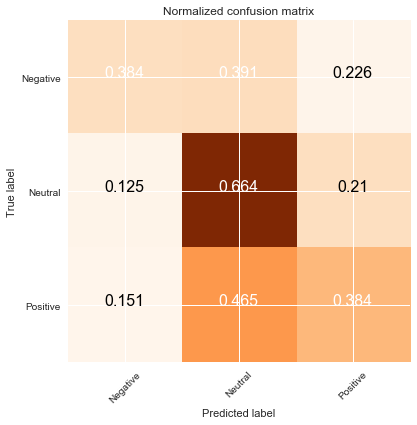

In [21]:
# Adapted from http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = cm.round(3)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
 

cnf_matrix = metrics.confusion_matrix(y_test,gb_mod.predict(X_test))

plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=["Negative","Neutral","Positive"], normalize=True,
                      title='Normalized confusion matrix')

The model performs best on classifying neutral responses. It appears that after that, the model performs better on positive responses than it does on negative responses.

Another way to visualize the performance is to plot an ROC curve. This is not so straightforward for multiclass classifiers, but one way to get around this issue is to fit three separate binary classifiers and plot the performance of each. By using scikit-learns OneVsRestClassifier, we can get 3 separate binary classifiers.

In [22]:
gb_mod_ovr = multiclass.OneVsRestClassifier(ensemble.GradientBoostingClassifier(n_estimators = 150, 
                                                                                max_features = 'sqrt', 
                                                                                learning_rate = 0.05, 
                                                                                max_depth = 2,
                                                                                subsample = 0.8))

gb_mod_ovr.fit(X_train,y_train)

OneVsRestClassifier(estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=2,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=150, presort='auto', random_state=None,
              subsample=0.8, verbose=0, warm_start=False),
          n_jobs=1)

We can confirm that the OneVsRest method does not significantly impact model performance.

In [23]:
print("Accuracy: %0.3f" % gb_mod_ovr.score(X_test,y_test))
print("F1 Score: %0.3f" % metrics.f1_score(y_test,gb_mod_ovr.predict(X_test),average="weighted"))

Accuracy: 0.499
F1 Score: 0.489


Now, we plot the ROC curves for the binary classifiers in the OneVsRest classifier.

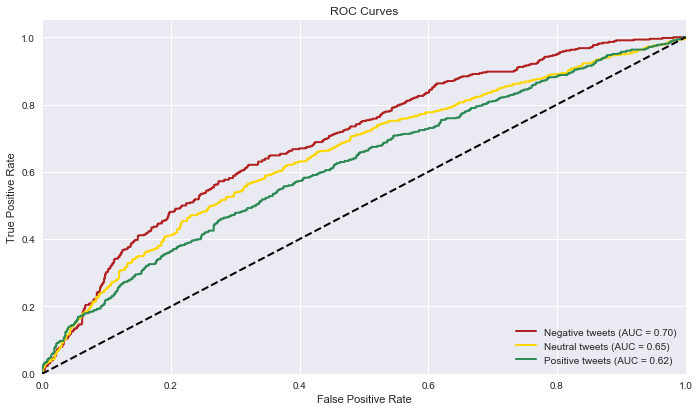

In [24]:
# Adapted from http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py

fpr = dict()
tpr = dict()
roc_auc = dict()

classes = ['neg','neu','pos']
class_names = ['Negative','Neutral','Positive']
n_classes = len(classes)

lw = 2

for i in range(0,n_classes):
    fpr[i], tpr[i], _ = metrics.roc_curve(y_test['sentiment_class'] == classes[i],gb_mod_ovr.estimators_[i].predict_proba(X_test)[:,1])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])
    
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(10,6))
colors = itertools.cycle(['firebrick', 'gold', 'seagreen'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='{0} tweets (AUC = {1:0.2f})'
             ''.format(class_names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc="lower right")
plt.tight_layout()

Each of these binary classifiers is performing above baseline. However, the negative vs. non-negative classifier is outperforming the positive vs. non-positive classifier. 

This might seem slightly unintuitive, as the confusion matrix suggested that the model was better at predicting when a response would be positive than predicting when a response would be negative. These results suggest that when forced to make a two-way classification of responses as negative vs. non-negative, the model can correctly classify responses as negative that it would have classified as positive if it was asked to make a three-way classification.

We can also take a look at feature importances. Below, the top ten features from the gradient boosting model are plotted.

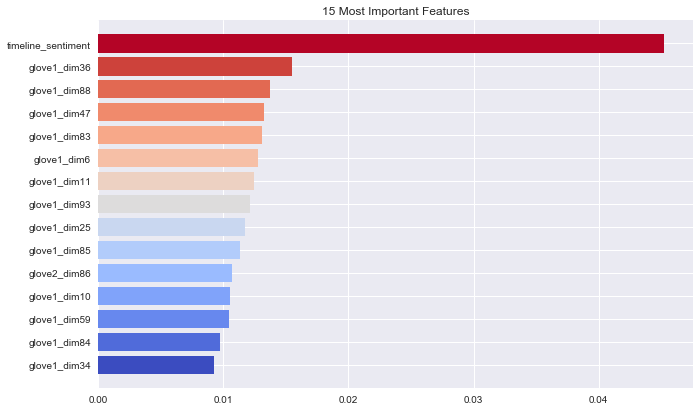

In [25]:
# Adapted from http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

importances = gb_mod.feature_importances_

indices = np.argsort(importances)[::-1][:15]

plt.figure(figsize=(10,6))
plt.title("15 Most Important Features")
plt.barh(range(15), importances[indices],
       color=cmx.ScalarMappable(cmap=plt.get_cmap("coolwarm")).to_rgba(map(lambda x: x / 15.,range(15)))[::-1], align="center")
plt.yticks(range(15), X_train.columns[indices])
plt.ylim([15, -1])
plt.tight_layout()

By far the most important feature is the average sentiment of a Twitter user's timeline before the response whose sentiment we want to predict. In addition to this, the majority of the most important features are GloVe dimensions associated with the replier's timeline.

These GloVe dimensions are directly interpretable, but overall we get the impression that the features useful for predicting the sentiment of a reply to a promoted tweet are features related to the replier, rather than features related to the company publishing the promoted tweet.